# Text Classification for Marketing Analytics Final Project

Imagine you're working at a media buying company, Chrishare. They have a new client, Theragun. 

Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. So, they’d like to find health and wellness news around the web to advertise on. Their goal with their media campaign is to identify as many news articles that mention health and wellness as possible. 

This is called contextual advertising: finding the URLs that match the context in which you’d like your ad to be shown. If you want to learn more about contextual advertising, I humbly recommend my non-credit Digital Advertising Strategy specialization on Coursera!

Your challenge now is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. You’ll be using the k-train, which is a wrapper for Tensorflow, Keras, and Huggingface Transformers.​

## Imports

In [1]:
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your google colab runtime to use GPU, a must for deep learning!

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 10 01:57:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the data

Load the data file from the Google Drive

In [3]:
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")

## Inspect the data

In [ ]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
reviews.shape

(200853, 6)

## Prepare the data

Most machine learning tools in Python accept one field/column/string. So I have to merge our two text column.

In [4]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

Rows in the healthy living category

In [ ]:
reviews[reviews['category'].str.contains("HEALTHY LIVING")]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,Loving a Narcissist Without Losing Yourself It...


Rows in the Wellness category

In [ ]:
reviews[reviews['category'].str.contains("WELLNESS")]

,category,headline,authors,link,short_description,date,combined_text
124989,WELLNESS,Why Overeating Doesn't Make You Fat,"Mark Hyman, MD, Contributor\nPracticing Physician",https://www.huffingtonpost.com/entry/overeatin...,If you take the right approach to ending your ...,2014-04-17,Why Overeating Doesn't Make You Fat If you tak...
124990,WELLNESS,14 Habits Of People With A Healthy Relationshi...,Sarah Klein,https://www.huffingtonpost.com/entry/healthy-r...,After a long list of rules and habits like the...,2014-04-17,14 Habits Of People With A Healthy Relationshi...
124993,WELLNESS,5 Things That Could Be Stealing Your Joy,"Amanda Gore, Contributor\nInternational keynot...",https://www.huffingtonpost.com/entry/joy_us_5b...,Listen to yourself all day today -- are you an...,2014-04-17,5 Things That Could Be Stealing Your Joy Liste...
124994,WELLNESS,Moments Make a Life,"Megan McDonough, Contributor\nCEO, Wholebeing ...",https://www.huffingtonpost.com/entry/moments-m...,Consciously constructing positive habits -- or...,2014-04-17,Moments Make a Life Consciously constructing p...
124996,WELLNESS,Fat Facts,"Maria Rodale, Contributor\nCEO and Chairman of...",https://www.huffingtonpost.com/entry/fat-facts...,"Human fat cells, photo by Dr. Peeke Here's how...",2014-04-17,"Fat Facts Human fat cells, photo by Dr. Peeke ..."
...,...,...,...,...,...,...,...
200797,WELLNESS,Shoveling Snow? How to Protect Your Back (And ...,,https://www.huffingtonpost.com/entry/shovel-sn...,"Work up to it. Warm up inside, and incorporate...",2012-01-28,Shoveling Snow? How to Protect Your Back (And ...
200799,WELLNESS,7 Reasons Working Too Much Is Bad For Your Health,Sarah Klein,https://www.huffingtonpost.com/entry/overtime-...,"If you're the last one to leave the office, or...",2012-01-28,7 Reasons Working Too Much Is Bad For Your Hea...
200800,WELLNESS,The Sleep Library: 11 Soothing Books For Bedtime,,https://www.huffingtonpost.comhttp://www.oprah...,Do you toss and turn until you finally sit up ...,2012-01-28,The Sleep Library: 11 Soothing Books For Bedti...
200802,WELLNESS,The Benefits of Caring for a Pet,"Rita Altman, R.N., Contributor\nSenior Vice Pr...",https://www.huffingtonpost.com/entry/pets-seni...,"For the young as well as the old, especially i...",2012-01-28,The Benefits of Caring for a Pet For the young...


Next, I have a categorical column that I want to turn into a "is this article healthy living or wellness?" column. That is, when an article is about healthy living or wellness, it should have a 1, when it's anything else, it should be a 0.

In [5]:
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)
reviews['wellness'] = np.where((reviews['category'] == 'WELLNESS'), 1, 0)


In [ ]:
reviews['healthy'].sum()

6694

In [ ]:
reviews['healthy'].describe()

count    200853.000000
mean          0.033328
std           0.179492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy, dtype: float64

In [ ]:
reviews['wellness'].sum()

17827

In [ ]:
reviews['wellness'].describe()

count    200853.000000
mean          0.088756
std           0.284393
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wellness, dtype: float64

## Training and Prediction (healthy)

To create a balanced data set, set sample_amount to 3000

In [18]:
sample_amount = 3000

healthy = reviews[reviews['healthy'] == 1].sample(n=sample_amount)
wellness = reviews[reviews['wellness'] == 1].sample(n=sample_amount)
not_healthy = reviews[(reviews['healthy'] == 0) & (reviews['wellness'] == 0)].sample(n=sample_amount)

In [19]:
review_sample = pd.concat([healthy,wellness,not_healthy])

In [20]:
review_sample['healthy'].describe()

count    9000.000000
mean        0.333333
std         0.471431
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: healthy, dtype: float64

Here, I will tune and train a predictor model for classifying healthy-living articles.

In [21]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

For purposes of this work, I use the distilbert-base-uncased transformer model. 

In [22]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_healthy', 'healthy']
        not_healthy  healthy
164549          1.0      0.0
137647          1.0      0.0
109626          0.0      1.0
67089           0.0      1.0
126728          1.0      0.0
['not_healthy', 'healthy']
        not_healthy  healthy
175053          1.0      0.0
177968          1.0      0.0
3671            1.0      0.0
122716          1.0      0.0
157207          1.0      0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 69


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 33
	95percentile : 60
	99percentile : 70


In [23]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
337/337 [==============================] - 626s 2s/step - loss: 0.6864 - accuracy: 0.5523
Epoch 2/6
337/337 [==============================] - 617s 2s/step - loss: 0.4610 - accuracy: 0.8057
Epoch 3/6
337/337 [==============================] - 616s 2s/step - loss: 0.4634 - accuracy: 0.7767
Epoch 4/6
337/337 [==============================] - 612s 2s/step - loss: 0.6971 - accuracy: 0.4989
Epoch 5/6
337/337 [==============================] - 234s 693ms/step - loss: 65.8411 - accuracy: 0.4778


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


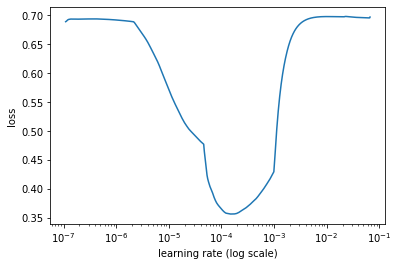

In [ ]:
learner.lr_plot()

Now, use the tuned learner to train the best model.

In [24]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
507/507 [==============================] - 458s 887ms/step - loss: 0.4876 - accuracy: 0.7575 - val_loss: 0.4092 - val_accuracy: 0.8144
Epoch 2/10
507/507 [==============================] - 457s 898ms/step - loss: 0.3323 - accuracy: 0.8477 - val_loss: 0.4283 - val_accuracy: 0.8211
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


Get the predictor

In [25]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [26]:
review_sample["IsHealthy_pred"] = predictor.predict(review_sample["combined_text"].values.tolist(), return_proba=True)[:,1]

Save the model

In [27]:
predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living_week5")

## Training and Prediction (wellness)

In [28]:
review_sample['wellness'].describe()

count    9000.000000
mean        0.333333
std         0.471431
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: wellness, dtype: float64

Here, I will tune and train a predictor model for classifying wellness articles.

In [29]:
target_names = ['NOT WELLNESS','WELLNESS']

For purposes of this work, I use the distilbert-base-uncased transformer model. 

In [30]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_wellness', 'wellness']
        not_wellness  wellness
126877           1.0       0.0
175881           1.0       0.0
56261            1.0       0.0
199047           0.0       1.0
199376           0.0       1.0
['not_wellness', 'wellness']
        not_wellness  wellness
77061            1.0       0.0
142430           0.0       1.0
186940           0.0       1.0
84400            1.0       0.0
143411           0.0       1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 59
	99percentile : 69


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 31
	95percentile : 59
	99percentile : 69


In [31]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [32]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
507/507 [==============================] - 461s 892ms/step - loss: 0.4226 - accuracy: 0.7725 - val_loss: 0.3334 - val_accuracy: 0.8244
Epoch 2/10
507/507 [==============================] - 458s 901ms/step - loss: 0.3036 - accuracy: 0.8567 - val_loss: 0.3288 - val_accuracy: 0.8256
Epoch 3/10
507/507 [==============================] - 459s 902ms/step - loss: 0.2127 - accuracy: 0.9068 - val_loss: 0.3657 - val_accuracy: 0.8278
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


Get the predictor

In [33]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [34]:
review_sample["IsWellness_pred"] = predictor.predict(review_sample["combined_text"].values.tolist(), return_proba=True)[:,1]

Save the model

In [35]:
predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.wellness_week5")

## Combine the results

In [37]:
review_sample["IsHW_true"] = ((review_sample['healthy'] == 1) | (review_sample['wellness'] == 1))
review_sample["IsHW_pred"] = ((review_sample['IsHealthy_pred'] >0.5) | (review_sample['IsWellness_pred'] >0.5))


In [39]:
from sklearn.metrics import classification_report

print(classification_report(review_sample["IsHW_true"], review_sample["IsHW_pred"]))

              precision    recall  f1-score   support

       False       0.74      0.93      0.83      3000
        True       0.96      0.84      0.89      6000

    accuracy                           0.87      9000
   macro avg       0.85      0.88      0.86      9000
weighted avg       0.89      0.87      0.87      9000



Since I use more articles about healthy living or wellness, I get better precision, recall, and F1 score, compared to week4 coursework.